In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [ ]:
#Импорт данных
df = pd.read_csv('AirPassengers.csv')
df = df.rename(columns={'Month': 'Date', '#Passengers': 'Passengers'})

df

,Date,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


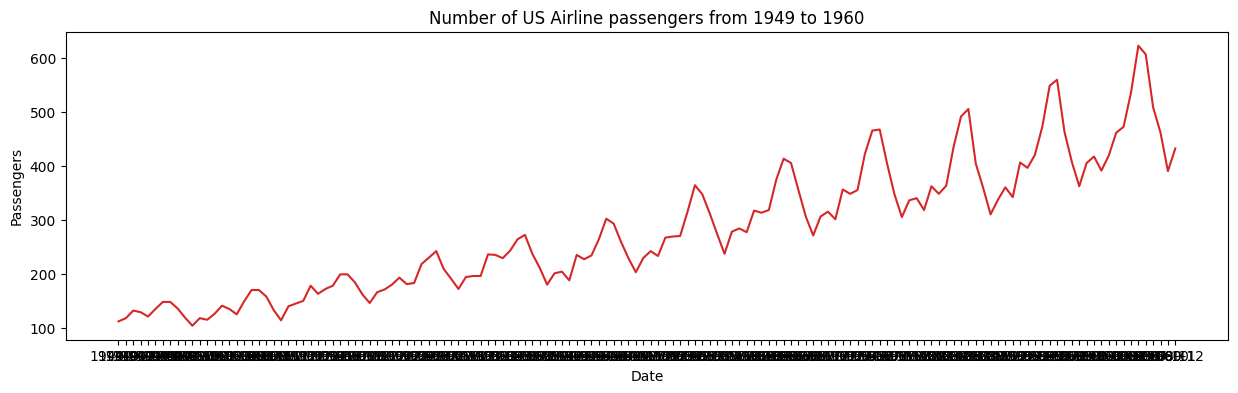

In [ ]:
#График количества пассажиров в Америке с 1949 по 1960

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df, x=df['Date'], y=df['Passengers'], title='Number of US Airline passengers from 1949 to 1960')

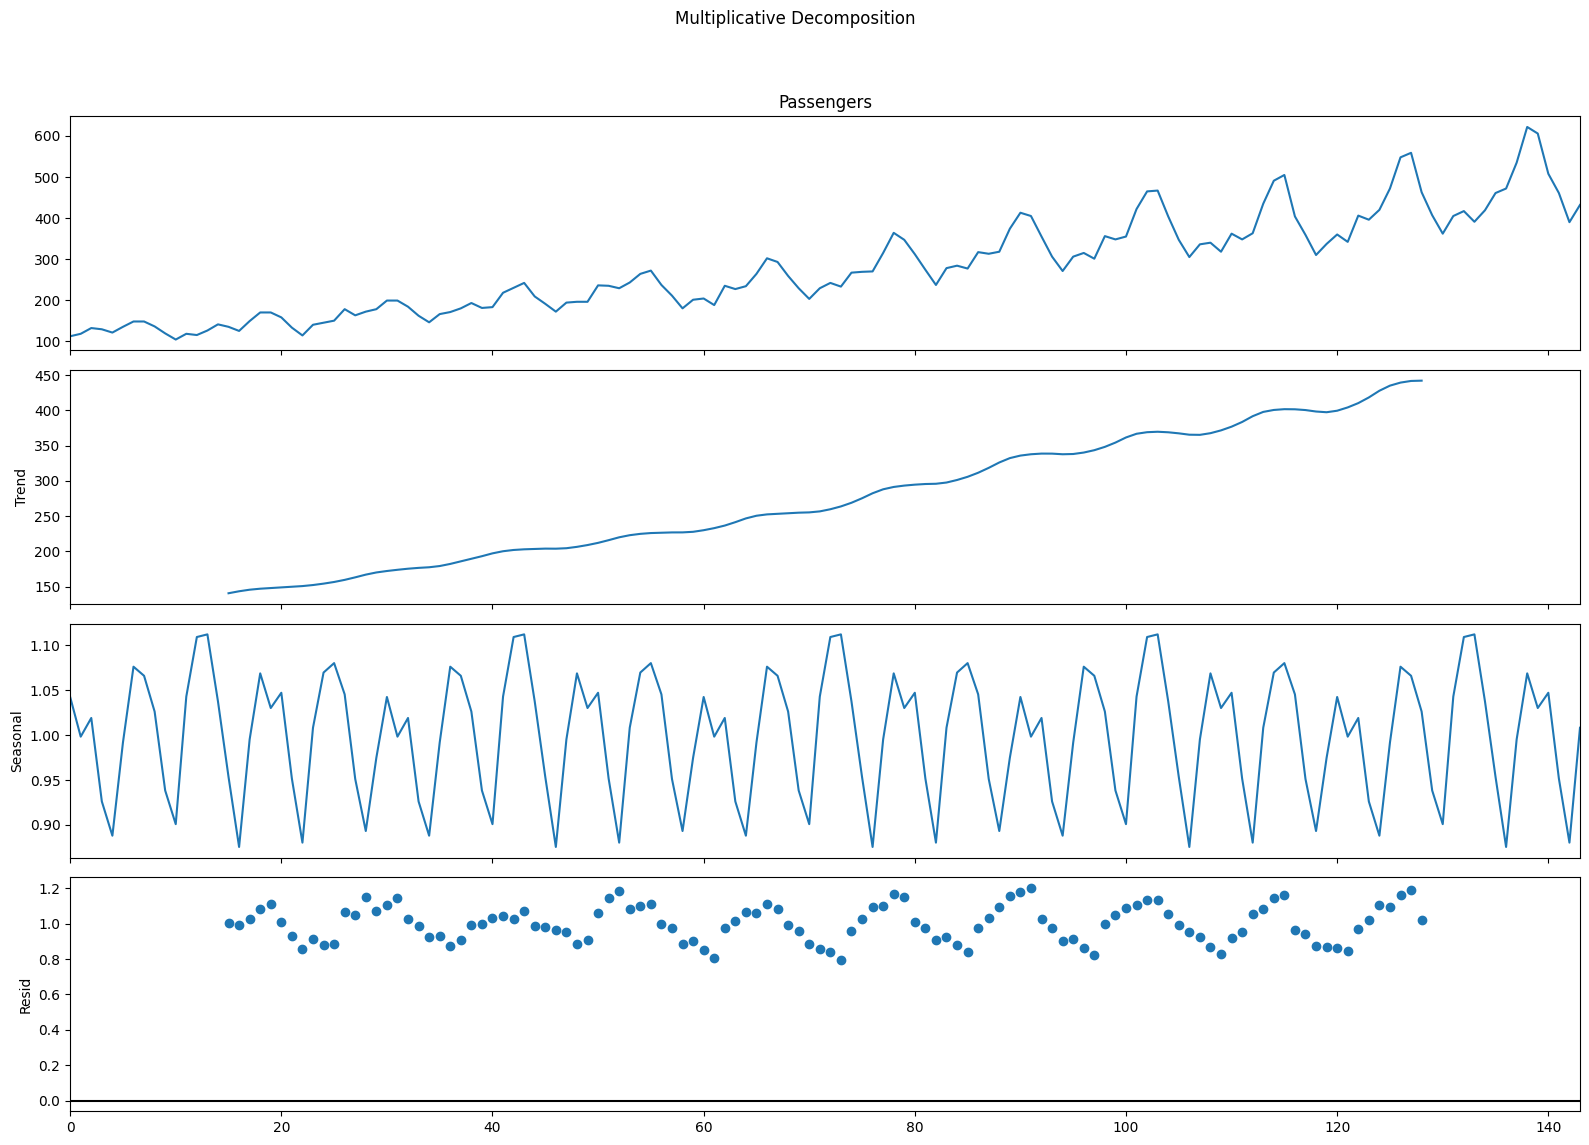

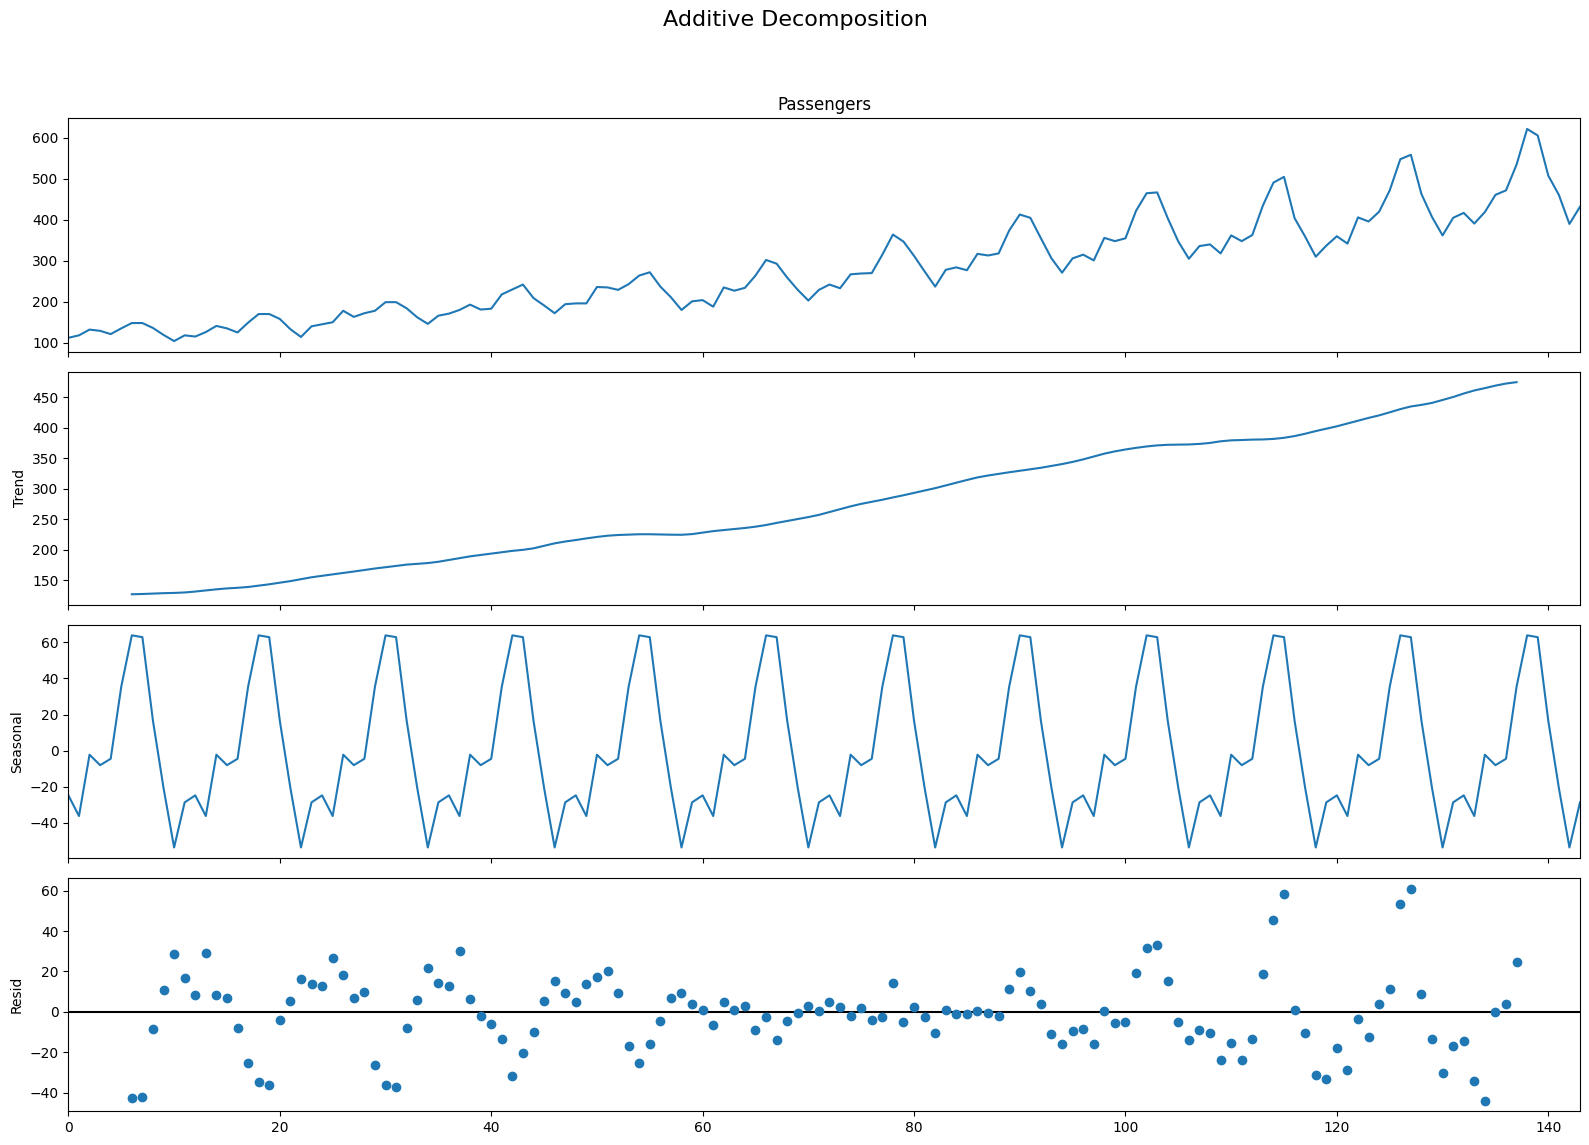

In [ ]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Passengers'], model='additive', period=12)

# Графики
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Text(0.5, 1.0, 'Air Passengers detrended by subtracting the trend component')

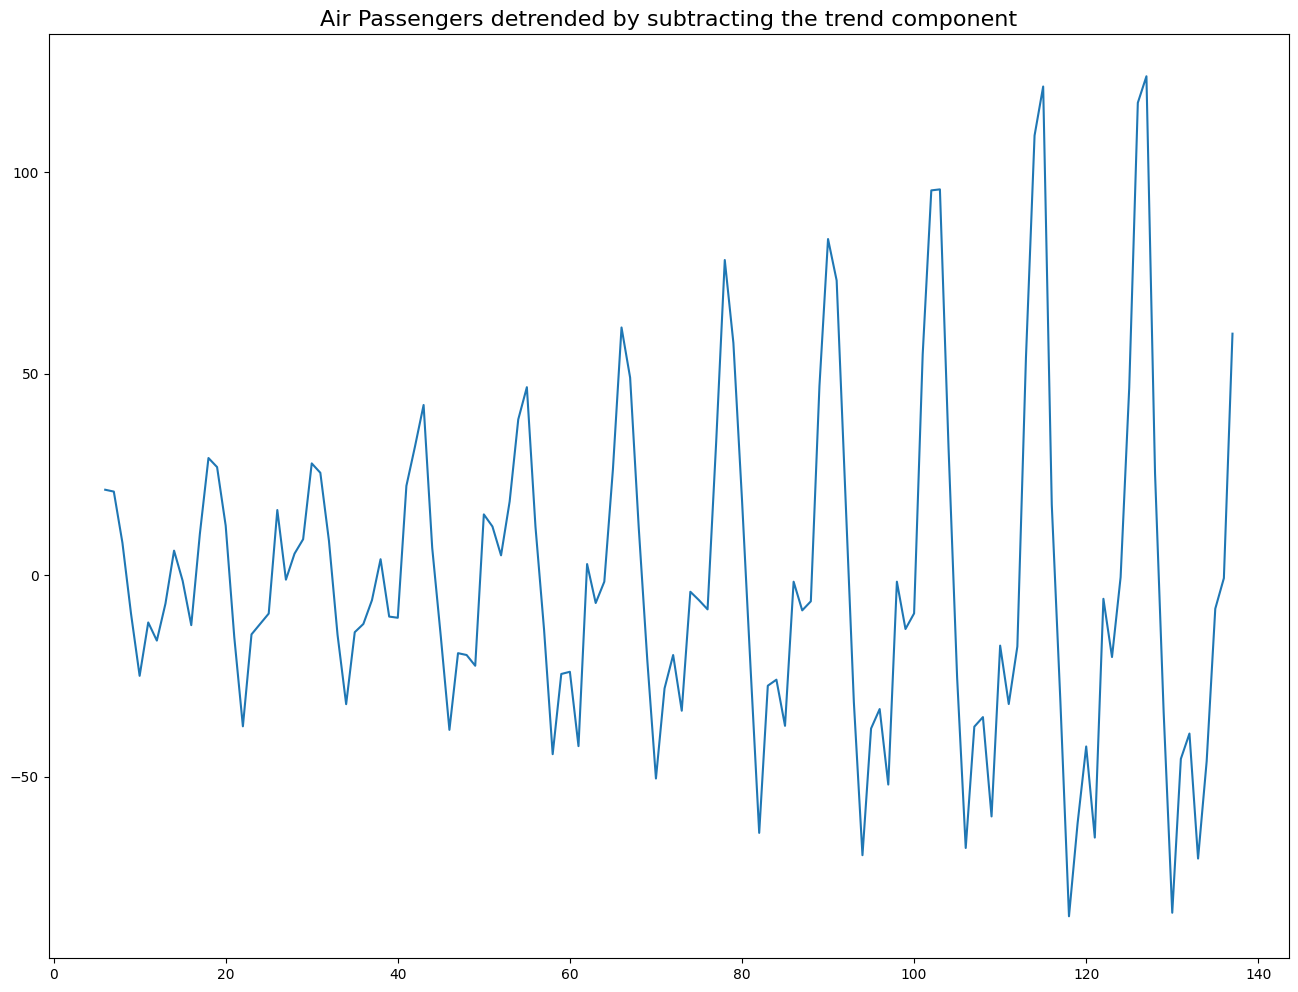

In [ ]:
# Детрендирование
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)
detrended = df['Passengers'].values - result_mul.trend
plt.plot(detrended)
plt.title('Air Passengers detrended by subtracting the trend component', fontsize=16)

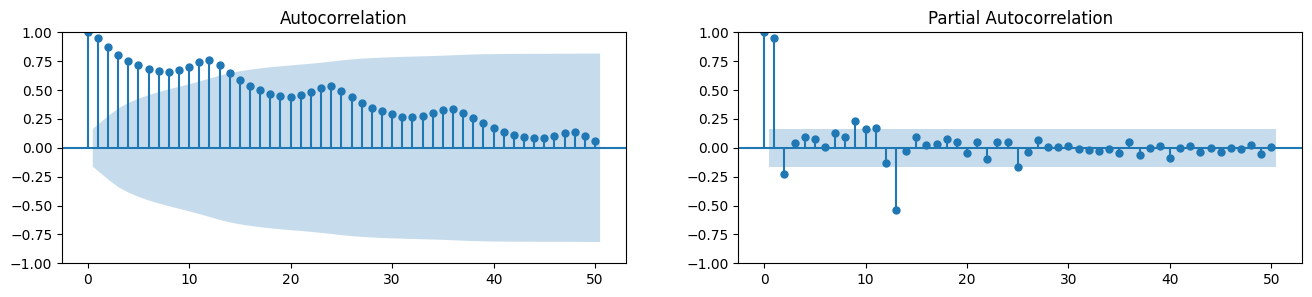

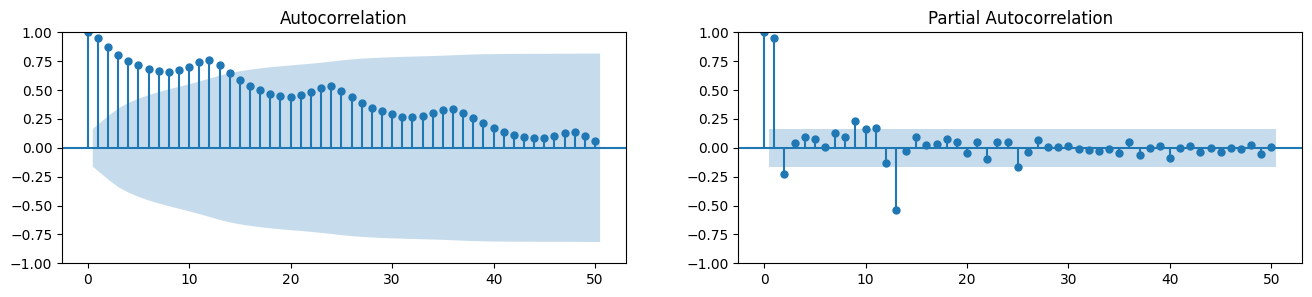

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Passengers'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Passengers'].tolist(), lags=50, ax=axes[1])

In [ ]:
data = df['Passengers'].values

train_size = int(len(data) * 0.8)  # 80% данных для тренировки
train, test = data[:train_size], data[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 115, Test size: 29


Optimal alpha: 0.16, beta: 0.01, gamma: 1.00, season_length: 12


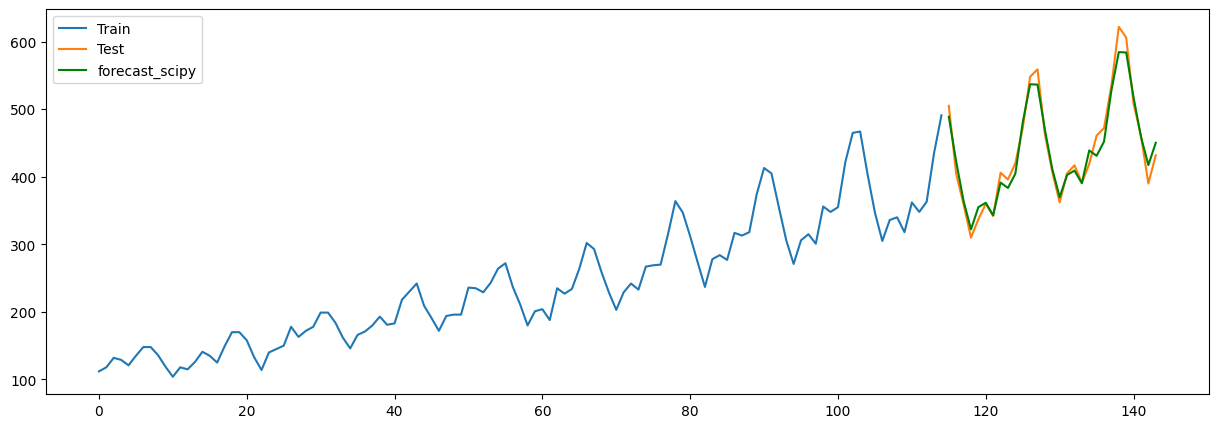

In [ ]:
# Реализация модели Хольта-Уинтерса
def holt_winters_forecast(data, alpha, beta, gamma, seasonal_periods, forecast_horizon):
    n = len(data)
    L = [0] * n
    T = [0] * n
    S = [0] * n
    forecast = [0] * (n + forecast_horizon)

    L[0] = data[0]
    T[0] = data[1] - data[0]
    S[:seasonal_periods] = [data[i] - L[0] for i in range(seasonal_periods)]

    for t in range(1, n):
        if t >= seasonal_periods:
            S[t] = gamma * (data[t] - (L[t-1] + T[t-1])) + (1 - gamma) * S[t-seasonal_periods]
        L[t] = alpha * (data[t] - S[t-seasonal_periods]) + (1 - alpha) * (L[t-1] + T[t-1])
        T[t] = beta * (L[t] - L[t-1]) + (1 - beta) * T[t-1]

    for h in range(1, forecast_horizon + 1):
        forecast[n + h - 1] = L[-1] + h * T[-1] + S[-seasonal_periods + (h % seasonal_periods) - 1]

    return forecast[-forecast_horizon:], L[-1], T[-1], S[-seasonal_periods:]

# Целевая функция для оптимизации
def objective_with_season(params):
    alpha, beta, gamma, season_length = params
    season_length = int(season_length)
    if season_length < 4:  # Минимальная длина сезона
        return np.inf

    forecast, _, _, _ = holt_winters_forecast(
        train,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        seasonal_periods=season_length,
        forecast_horizon=len(test)
    )
    return mean_squared_error(test, forecast)

# Оптимизация гиперпараметров
bounds = [(0.01, 1), (0.01, 1), (0.01, 1), (4, 24)]  # Длина сезона от 4 до 24
res = minimize(objective_with_season, x0=[0.1, 0.1, 0.1, 12], bounds=bounds, method='L-BFGS-B')
alpha_opt, beta_opt, gamma_opt, season_length_opt = res.x
season_length_opt = int(season_length_opt)

print(f"Optimal alpha: {alpha_opt:.2f}, beta: {beta_opt:.2f}, gamma: {gamma_opt:.2f}, season_length: {season_length_opt}")

# Прогноз для (scipy.optimize)
forecast_scipy, _, _, _ = holt_winters_forecast(
    train,
    alpha=alpha_opt,
    beta=beta_opt,
    gamma=gamma_opt,
    seasonal_periods=season_length_opt,
    forecast_horizon=len(test)
)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(forecast_scipy)), forecast_scipy, label='forecast_scipy', color='green')
plt.legend()
plt.show()


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

# Улучшенная целевая функция для Optuna
def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 0.01, 1.0)
    beta = trial.suggest_loguniform("beta", 0.01, 1.0)
    gamma = trial.suggest_loguniform("gamma", 0.01, 1.0)
    season_length = trial.suggest_int("season_length", 4, 12)

    try:
        forecast, _, _, _ = holt_winters_forecast(
            train,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            seasonal_periods=season_length,
            forecast_horizon=len(test)
        )
        error = mean_squared_error(test, forecast)
        return error
    except:
        return float("inf")  # На случай ошибки модели

# Запуск оптимизации с TPE для лучшего поиска гиперпараметров
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=1000)  # Увеличиваем количество проб

# Результаты
print("Best parameters:", study.best_params)
print("Best error:", study.best_value)

best_params = study.best_params
alpha_opt, beta_opt, gamma_opt, season_length_opt = (
    best_params["alpha"],
    best_params["beta"],
    best_params["gamma"],
    best_params["season_length"],
)

print(f"Optimal alpha: {alpha_opt:.2f}, beta: {beta_opt:.2f}, gamma: {gamma_opt:.2f}, season_length: {season_length_opt}")


Streaming output truncated to the last 5000 lines.
  gamma = trial.suggest_loguniform("gamma", 0.01, 1.0)
[I 2024-11-18 12:50:57,952] Trial 285 finished with value: 446.0707810568279 and parameters: {'alpha': 0.09583630045439576, 'beta': 0.01283205232756259, 'gamma': 0.6038346208905282, 'season_length': 12}. Best is trial 274 with value: 379.2697861941142.
<ipython-input-17-762a03900506>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 0.01, 1.0)
<ipython-input-17-762a03900506>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  beta = trial.suggest_loguniform("beta", 0.01, 1.0)
<ipython-input-17-762a03900506>:8: FutureWarning: sug

Best parameters: {'alpha': 0.16249108570500742, 'beta': 0.010006977395932856, 'gamma': 0.9986545675534207, 'season_length': 12}
Best error: 255.652574051538
Optimal alpha: 0.16, beta: 0.01, gamma: 1.00, season_length: 12


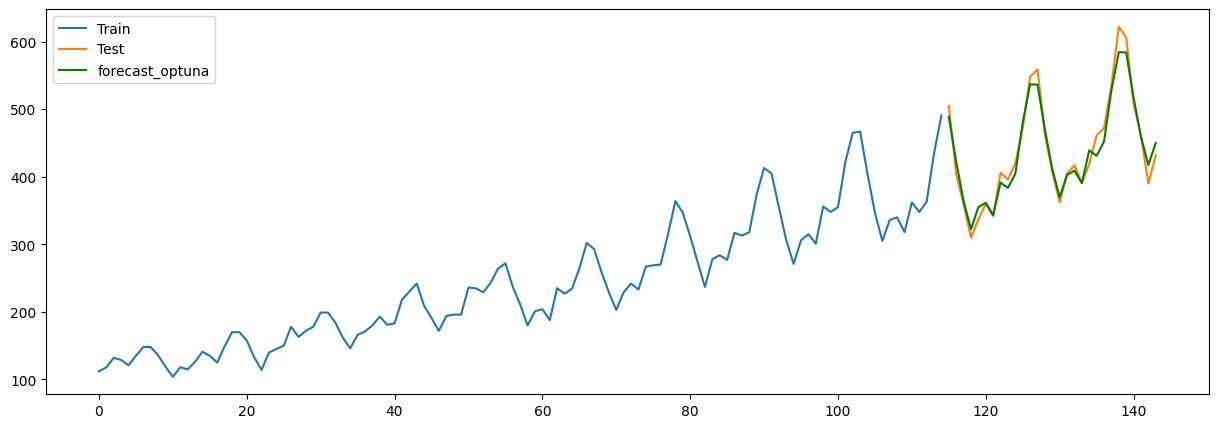

In [18]:
forecast_optuna, _, _, _ = holt_winters_forecast(
    train,
    alpha=alpha_opt,
    beta=beta_opt,
    gamma=gamma_opt,
    seasonal_periods=season_length_opt,
    forecast_horizon=len(test)
)

# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(forecast_optuna)), forecast_optuna, label='forecast_optuna', color='green')
plt.legend()
plt.show()

MSE for Optuna optimized model: 255.65
MSE for Scipy optimized model: 255.50


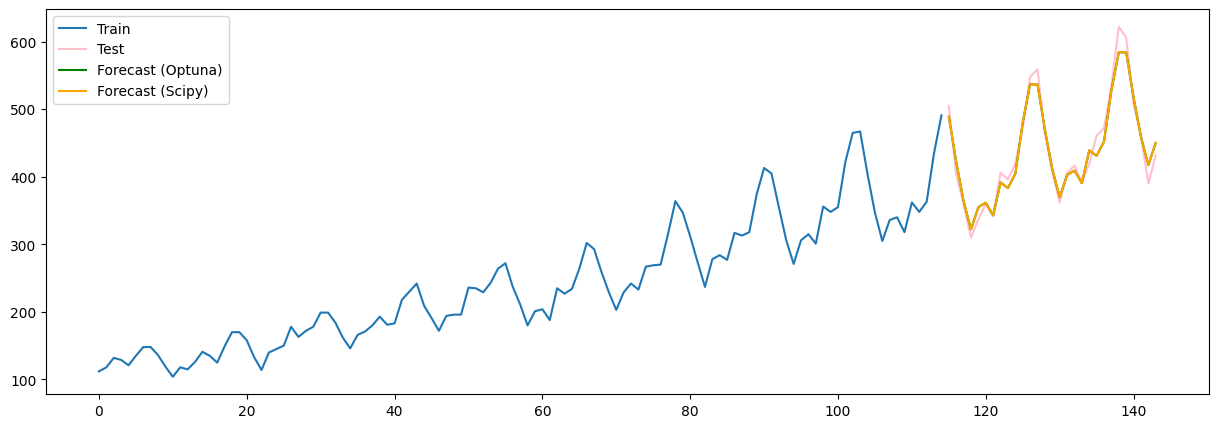

In [19]:
# Вычисление MSE для сравнения качества прогнозов
mse_optuna = mean_squared_error(test, forecast_optuna)
mse_scipy = mean_squared_error(test, forecast_scipy)

print(f"MSE for Optuna optimized model: {mse_optuna:.2f}")
print(f"MSE for Scipy optimized model: {mse_scipy:.2f}")

# Построение графика для сравнения
plt.figure(figsize=(15, 5))

# Тренировочные данные
plt.plot(range(len(train)), train, label='Train')

# Тестовые данные
plt.plot(range(len(train), len(train) + len(test)), test, label='Test', color='pink')

# Прогноз для Optuna
plt.plot(range(len(train), len(train) + len(forecast_optuna)), forecast_optuna, label='Forecast (Optuna)', color='green')

# Прогноз для scipy
plt.plot(range(len(train), len(train) + len(forecast_scipy)), forecast_scipy, label='Forecast (Scipy)', color='orange')

plt.legend()
plt.show()